# William Kiger - Kristopher Gallagher
Spring 2023 DLH 598 Final Project
RAPS Implemented as in https://arxiv.org/abs/2009.14193 
and https://github.com/aangelopoulos/conformal_classification

In [1]:
import os
import sys
import random
import time
import numpy as np
import matplotlib.pyplot as plt 

#imports from Conforamal RAPS
from conformal_raps.conformal import *
from conformal_raps.utils import *

#PyTorch imports
import torch
import torchvision
import torchvision.transforms as transforms
import torch.backends.cudnn as cudnn

# Setting up our transforms for infernece

In [2]:
#setting seeds to 0 for reproducability
np.random.seed(seed=0)
torch.manual_seed(0)
torch.cuda.manual_seed(0)
random.seed(0)

# Normalization from torchvision repo
transform = transforms.Compose([
                transforms.Resize(256),
                transforms.CenterCrop(224),
                transforms.ToTensor(),
                transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                      std= [0.229, 0.224, 0.225])
            ])

In [3]:
cudnn.benchmark = True
batch_size = 128
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("Device = " + str(device))

Device = cuda:0


# Load our model

In [4]:
model_path = r"model/resnet_18_derm_model_test_v2.pt"
model = torch.load(model_path)
# model.to(device)
model = torch.nn.DataParallel(model)  # wdk...for multi-gpu instances
#model to eval mode
_ = model.eval()

# Get the conformal calibration and validation datasets

In [5]:
root = r'data\validation_dataset'
validate_path = os.path.join(root, 'val')

calibration_dataset, validation_dataset = torch.utils.data.random_split(
    torchvision.datasets.ImageFolder(validate_path, transform), [100, 890-100]) #[num, num_image-num]

calib_loader = torch.utils.data.DataLoader(
    calibration_dataset, batch_size=batch_size, shuffle=True, pin_memory=True)
val_loader = torch.utils.data.DataLoader(
    validation_dataset, batch_size=batch_size, shuffle=True, pin_memory=True)

# Conformalize the model - perform platt scaling and then wrap the model with RAPS

In [6]:
cmodel = ConformalModel(model, calib_loader, alpha=0.1, lamda_criterion='size')

Begin Platt scaling.
Computing logits for model (only happens once).


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:04<00:00,  4.84s/it]

Optimal T=1.2990543842315674


# Validate the coverage of the conformal model and validation sets.  Note that the running averages of coverage and size are in parenthesis.  

In [7]:
top1, top5, coverage, size = validate(val_loader, cmodel, print_bool=True)

N: 790 | Time: 0.393 (0.945) | Cvg@1: 0.318 (0.272) | Cvg@5: 0.864 (0.758) | Cvg@RAPS: 0.955 (0.856) | Size@RAPS: 6.773 (6.651)


# Now use RAPS 

In [8]:
#prefilling parameters
num_images = 890
num_calib = 100

class_names = {0: 'allergic_contact_dermatitis', 1: 'basal_cell_carcinoma', 2: 'folliculitis', 
               3: 'lichen_planus', 4: 'lupus_erythematosus', 5: 'neutrophilic_dermatoses', 
               6: 'photodermatoses', 7: 'psoriasis', 8: 'sarcoidosis', 9: 'squamous_cell_carcinoma'}
class_names = list(class_names.values())

Image 0 has label 'allergic_contact_dermatitis', and the predictive set is ['psoriasis', 'allergic_contact_dermatitis', 'photodermatoses', 'lupus_erythematosus', 'lichen_planus', 'neutrophilic_dermatoses'].
Image 1 has label 'basal_cell_carcinoma', and the predictive set is ['squamous_cell_carcinoma', 'psoriasis', 'neutrophilic_dermatoses', 'basal_cell_carcinoma', 'allergic_contact_dermatitis', 'lupus_erythematosus', 'sarcoidosis'].
Image 2 has label 'folliculitis', and the predictive set is ['psoriasis', 'allergic_contact_dermatitis', 'photodermatoses', 'lupus_erythematosus', 'sarcoidosis', 'neutrophilic_dermatoses', 'lichen_planus'].
Image 3 has label 'lichen_planus', and the predictive set is ['folliculitis', 'basal_cell_carcinoma', 'lichen_planus', 'allergic_contact_dermatitis', 'squamous_cell_carcinoma', 'psoriasis', 'sarcoidosis'].
Image 4 has label 'lupus_erythematosus', and the predictive set is ['psoriasis', 'allergic_contact_dermatitis', 'photodermatoses', 'lupus_erythematosu

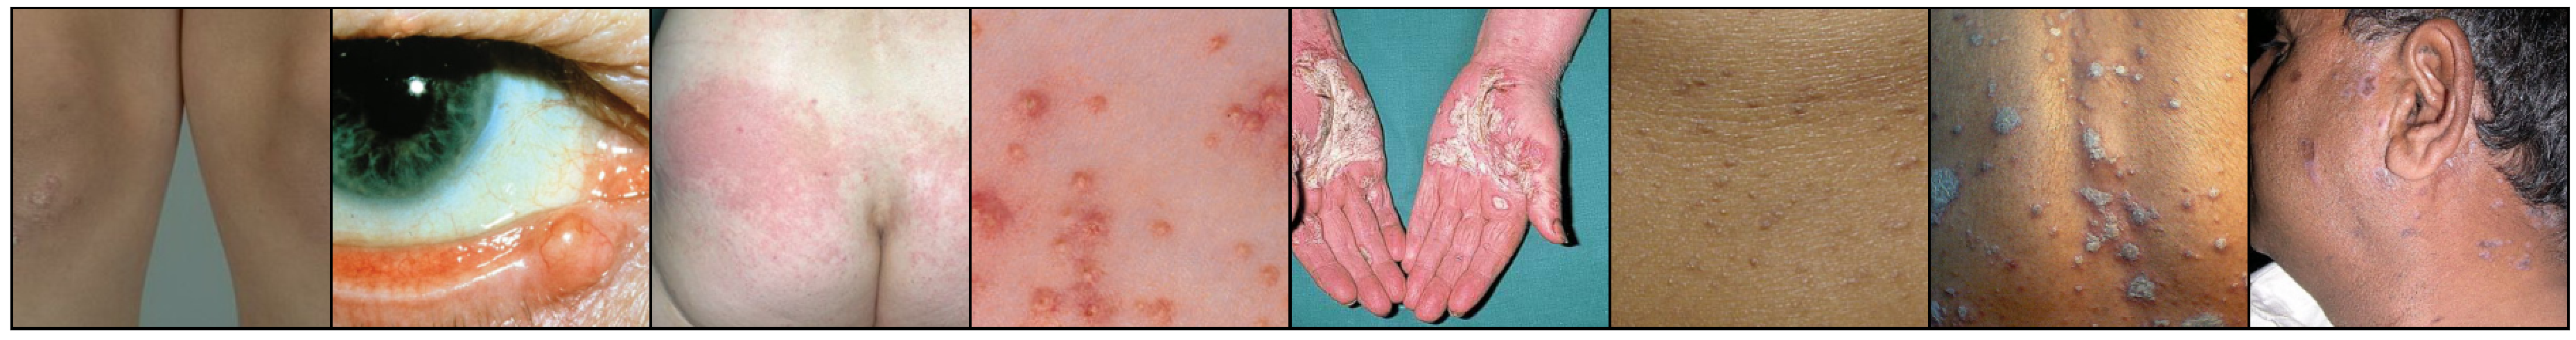

In [9]:
num_images = 8
explore_data, _ = torch.utils.data.random_split(validation_dataset, [num_images, 890-num_calib-num_images])

mosaiclist = []
sets = []
labels = class_names

for data in explore_data:
    img, label = data
    scores, set = cmodel(img.view(1,3,224,224).cuda())
    unnormalized_img = (img * torch.Tensor([0.229, 0.224, 0.225]).view(-1,1,1))+torch.Tensor([0.485, 0.456, 0.406]).view(-1,1,1)
  
    set = [class_names[s] for s in set[0]]
    sets = sets + [set]
    labels = labels + [class_names[label]]
    mosaiclist = mosaiclist + [unnormalized_img]

grid = torchvision.utils.make_grid(mosaiclist)

fig, ax = plt.subplots(figsize=(min(num_images,9)*5, np.floor(num_images/9+1)*5))
ax.imshow(grid.permute(1,2,0), interpolation='nearest')
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
plt.tight_layout()

for i in range(len(mosaiclist)):
    print(f"Image {i} has label \'{labels[i]}\', and the predictive set is {sets[i]}.")

# This is showing that our not-so-great model has offered the set of predictions for the medical practicioner to further descriminate the inferences